/var/folders/5g/hyv5_r417lgcw4q4fw84b9nw0000gn/T/ipykernel_14518/3141712914.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E[i + 1] = E[i] + dt * dedt(t[i], E[i], I[i], P)


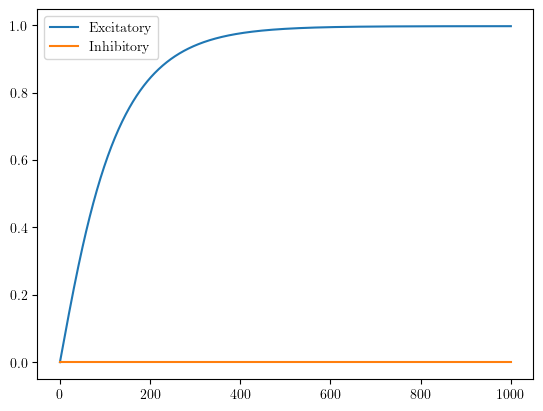

In [4]:
import numpy as np
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('animation', html='jshtml')

# constants
r = .2
tau_E = 1.
tau_I = 2.

P = .2
Q = .5

w_ee = 10
w_ei = 12
w_ie = 9
w_ii = 3
k = 5

import numpy as np 
def sig(x):
    return 1/(1 + np.exp(-x))

def tanh(x):
    return 2*sig(2*x) - 1

def dedt(t, E, I, P):
    # de = (-E + (1 - r*E)*sig(w_ee*E - w_ei*I + P)) / tau_E
    de = (-E + sig(k*E + k*P)) / tau_E
    return np.array([de])

def didt(t, E, I, Q):
    di = (-I + (1 - r*I)*tanh(w_ie*E - w_ii*I + Q)) / tau_I
    return np.array([di])

T = 10
dt = .01
t = np.arange(0, T + dt, dt)
E = np.zeros(len(t))
I = np.zeros(len(t))

for i in range(len(t) - 1):
    E[i + 1] = E[i] + dt * dedt(t[i], E[i], I[i], P)
    # I[i + 1] = I[i] + dt * didt(t[i], E[i], I[i], Q)

plt.plot(E, label='Excitatory')
plt.plot(I, label='Inhibitory')
plt.legend()

np.save('E_synthetic_k5_Pdot2.npy', E)

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def wilson_cowan_dynamics(E_t, tau, k, P):
    dE_dt = -E_t / tau + sigmoid(k * E_t + P)
    return E_t + dE_dt

def generate_data(tau_true, k_true, P_true, T, noise_std=0.001):
    E = np.zeros(T)
    E[0] = np.random.uniform(0, 1)
    for t in range(1, T):
        E[t] = wilson_cowan_dynamics(E[t-1], tau_true, k_true, P_true) + np.random.normal(0, noise_std)
    return E

tau_true, k_true, P_true = 1.0, 1.5, 0.5
T = 100
data = generate_data(tau_true, k_true, P_true, T)

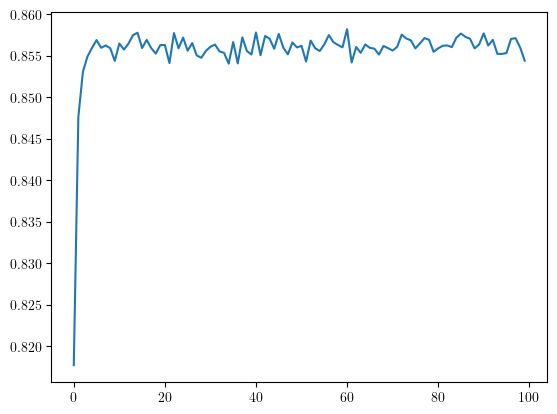

In [13]:
plt.plot(data)

In [5]:
import numpy as np
from pgmpy.models import FactorGraph
from pgmpy.factors.discrete import DiscreteFactor

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def wilson_cowan_dynamics(E_t, E_tp1, tau, k, P):
    dE_dt = -E_t / tau + sigmoid(k * E_t + P)
    E_pred = E_t + dE_dt  # Simple Euler integration
    return np.exp(-0.5 * (E_tp1 - E_pred)**2)

# Generate synthetic data
def generate_data(tau_true, k_true, P_true, T, noise_std=0.1):
    E = np.zeros(T)
    E[0] = np.random.uniform(0, 1)
    for t in range(1, T):
        dE_dt = -E[t-1] / tau_true + sigmoid(k_true * E[t-1] + P_true)
        E[t] = E[t-1] + dE_dt + np.random.normal(0, noise_std)
    return E

tau_true, k_true, P_true = 1.0, 1.5, 0.5
T = 100
data = generate_data(tau_true, k_true, P_true, T)

# Create a FactorGraph
model = FactorGraph()

# Add variable nodes for E, tau, k, and P
for t in range(T):
    model.add_node(f"E_{t}")
model.add_node("tau")
model.add_node("k")
model.add_node("P")

# Add observation factors
for t in range(T):
    obs_factor = DiscreteFactor([f"E_{t}"], [50], np.exp(-0.5 * (np.linspace(0, 1, 50) - data[t])**2 / 0.01))
    model.add_factors(obs_factor)

# Add dynamics factors
for t in range(T - 1):
    dyn_factor = DiscreteFactor([f"E_{t}", f"E_{t+1}", "tau", "k", "P"], 
                               [50, 50, 20, 20, 20], 
                               [[[[[wilson_cowan_dynamics(i/50, j/50, tau/10, k/10, P/10) 
                                   for P in range(20)]
                                  for k in range(20)]
                                 for tau in range(1, 21)]
                                for j in range(50)]
                               for i in range(50)])
    model.add_factors(dyn_factor)

# Define the negative log-likelihood
def neg_log_likelihood(params):
    tau, k, P = params
    likelihood = 1.0
    for t in range(T - 1):
        E_t = data[t]
        E_tp1 = data[t + 1]
        likelihood *= wilson_cowan_dynamics(E_t, E_tp1, tau, k, P)
    return -np.log(likelihood)

# Perform gradient descent
from scipy.optimize import minimize

initial_guess = [1.1, 1.6, 0.6]  # Initial guess for [tau, k, P]
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B')

tau_est, k_est, P_est = result.x
print(f"True parameters: tau={tau_true}, k={k_true}, P={P_true}")
print(f"Estimated parameters: tau={tau_est}, k={k_est}, P={P_est}")

True parameters: tau=1.0, k=1.5, P=0.5
Estimated parameters: tau=1.1, k=1.6, P=0.6


/var/folders/5g/hyv5_r417lgcw4q4fw84b9nw0000gn/T/ipykernel_38830/3751153442.py:61: RuntimeWarning: divide by zero encountered in log
  return -np.log(likelihood)
/Users/siddharthsrivastava/.pyenv/versions/3.10.12/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
